Preamble: these imports are needed for this notebook to work

In [4]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


## Classes and inheritance

+ Classes are abstract Python objects that bundle variables and functions, which are usually called "methods" in this context
+ Classes are useful for keeping track of the state of a simulation
+ All classes have constructor methods, where Python reserves space for the object and sets the initial values of variables bound to the class, which are called "instance variables" in this context

Hierarchical inheritance (most common)
+ Multiple child classes inherit shared methods from a parent class

Multiple inheritance (common in machine learning)
+ Child merges methods from a shared parent

# A basic class

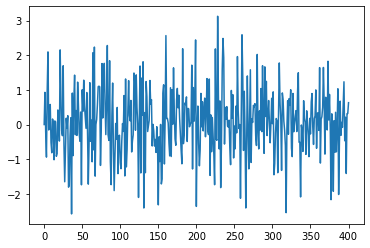

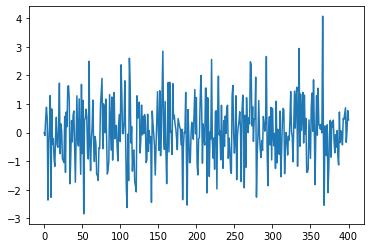

In [22]:
import random
class OrnsteinUhlenbeckProcess:
    """
    A class for generating Ornstein-Uhlenbeck processes.
    """
    # Constructor (mandatory for isolated class)
    def __init__(self, alpha, sigma):
        self.alpha = alpha
        self.sigma = sigma

    def step(self, x):
        drift = -self.alpha * x
        diffusion = self.sigma * random.gauss(0, 1)
        return drift + diffusion

    def run_process(self, n_steps):
        all_steps = [0]
        for i in range(n_steps):
            all_steps.append(self.step(all_steps[-1]))
        return all_steps

process1 = OrnsteinUhlenbeckProcess(0.1, 1.0)
traj = process1.run_process(400)

plt.figure()
plt.plot(traj)



process2 = OrnsteinUhlenbeckProcess(0.001, 1.0)
traj = process2.run_process(400)

plt.figure()
plt.plot(traj)


In [25]:
traj = OrnsteinUhlenbeckProcess(0.001, 1.0).run_process(400)


## Inheritance

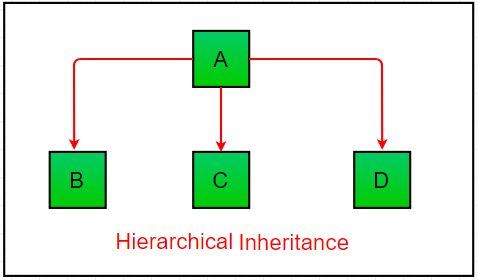

In [13]:
Image("../resources/inheritance_tree.png")
# Source: https://www.geeksforgeeks.org/types-of-inheritance-python/

In [88]:
class StochasticProcess:
    """
    A base class for stochastic processes.

    Parameters
        start_val (float): The starting value of the process
        dim (int): The dimension of the process
        drift_level (float): The drift level of the process
        noise_level (float): The noise level of the process
        store_history (bool): Whether to store the history of the process
        random_state (int): The random state to use for reproducibility

    """

    def __init__(self, start_val, dim, drift_level=0.25, noise_level=1.0, 
        store_history=True, random_state=None
    ):
        self.dim = dim
        self.start_val = start_val
        self.drift_level = drift_level
        self.noise_level = noise_level

        self.store_history = store_history
        self.random_state = random_state

        self.state = start_val
        if self.store_history:
            self.history = [self.state]


    def run_process(self, num_steps):
        """
        Run the process for num_steps.
        """
        np.random.seed(self.random_state)
        for i in range(num_steps):
            self.state = self.step()
            if self.store_history:
                self.history.append(self.state)

        return self.state

    def step(self):
        """
        Subclasses should implement this method. Defaults to Identity process
        """
        raise NotImplementedError




## These subclasses are the different types of stochastic processes, and so they 
## inherit methods from the StochasticProcess class.

        
class IdentityProcess(StochasticProcess):
    """
    An identity process.

    Parameters
        start_val (float): The starting value of the process
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.
    """
    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, **kwargs)
        ## super() is a function that calls the constructor of the parent class(es)

        

    def step(self):
        return self.state


class WienerProcess(StochasticProcess):
    """
    A Wiener process.

    Parameters
        start_val (float): The starting value of the process
        noise_level (float): The standard deviation of the noise
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.
    """
    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, 1.0, **kwargs)

    def step(self):
        return self.state + np.random.normal(0, self.noise_level)

class OrnsteinUhlenbeckProcess(StochasticProcess):
    """
    An Ornstein-Uhlenbeck process.

    Parameters
        start_val (float): The starting value of the process
        drift_level (float): The magnitude of the deterministic forcing term
        noise_level (float): The standard deviation of the noise
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.

    """

    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, **kwargs)

    def step(self):
        return self.state + self.drift_level * (0 - self.state) + np.random.normal(0, self.noise_level)


class GeometricBrownianMotionProcess(StochasticProcess):
    """
    A geometric Brownian motion process.

    Parameters
        start_val (float): The starting value of the process
        drift_level (float): The magnitude of the deterministic forcing term
        noise_level (float): The standard deviation of the noise
        **kwargs (dict): Keyword arguments to pass to the StochasticProcess constructor.

    """
    def __init__(self, start_val, **kwargs):
        super().__init__(start_val, 1, **kwargs)

    def step(self):
        return self.state * (1 + self.drift_level + np.random.normal(0, self.noise_level))


Text(0.5, 1.0, 'Ornstein-Uhlenbeck Process')

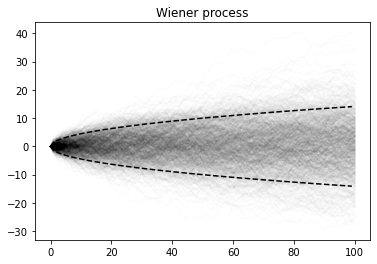

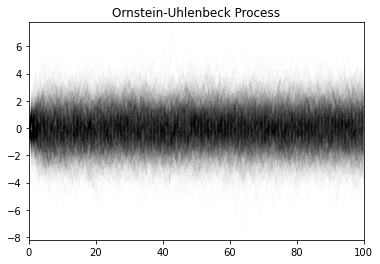

In [98]:
plt.figure()
for i in range(1000):
    process = WienerProcess(0.0, store_history=True)
    process.run_process(100)
    plt.plot(process.history, color="black", alpha=0.01)

plt.plot(np.arange(0, 100), np.sqrt(2 * np.arange(0, 100)), color="black", linestyle="--")
plt.plot(np.arange(0, 100), -np.sqrt(2 * np.arange(0, 100)), color="black", linestyle="--")
plt.title("Wiener process")



plt.figure()
for i in range(1000):
    process = OrnsteinUhlenbeckProcess(0.0, store_history=True)
    process.run_process(100)
    plt.plot(process.history, color="black", alpha=0.01)
plt.xlim([0, 100])
plt.title("Ornstein-Uhlenbeck Process")

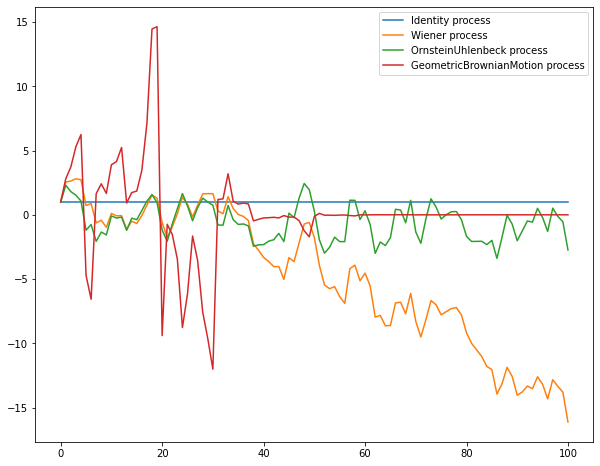

In [92]:
process_names = ["Identity", "Wiener", "OrnsteinUhlenbeck", "GeometricBrownianMotion"]

plt.figure(figsize=(10, 8))
for process_name in process_names:
    process = eval(process_name + "Process")(1.0, store_history=True, random_state=14)
    process.run_process(100)
    plt.plot(process.history)


    process.run_process(1000)

plt.legend([process_name + " process" for process_name in process_names])


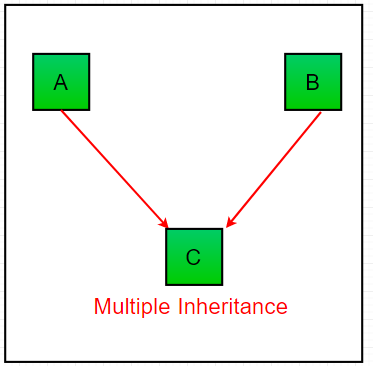

In [15]:
Image("../resources/multiple_inheritance.png")
# Source: https://www.geeksforgeeks.org/types-of-inheritance-python/

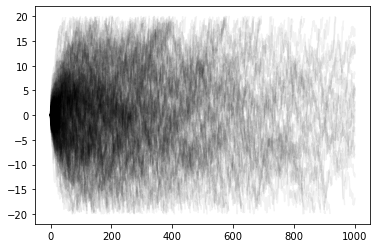

In [64]:
class HaltingProcess:
    """
    A base class for halting processes.
    
    Parameters
        threshold (float): The threshold at which the process halts
    """
    def __init__(self, threshold):
        self.threshold = threshold
        self.store_history = True

    def step(self):
        """
        Subclasses or sibling classes should implement this method
        """
        raise NotImplementedError

    def run_halting_process(self, max_iter=1000):
        """
        Run a halting process, which is a stochastic process that halts when a threshold 
            is reached. If the threshold is not reached after max_iter, then the process
            is halted and the last value is returned.
        """
        np.random.seed(self.random_state)
        for i in range(max_iter):
            self.state = self.step()
            if np.abs(self.state) > self.threshold:
                break
            if self.store_history:
                self.history.append(self.state)

        return self.state



class BrownianHaltingProcess(WienerProcess, HaltingProcess):
    # The order matters here

    def __init__(self, start_val, threshold, **kwargs):
        HaltingProcess.__init__(self, threshold)
        WienerProcess.__init__(self, start_val, **kwargs)
        # The order does not matter here
        




plt.figure()
for i in range(300):
    model = BrownianHaltingProcess(0.0, 20.0, store_history=True)
    model.run_halting_process()
    plt.plot(model.history, color="black", alpha=0.05)



# The Game of Life and Cellular Automata

+ Cellular automata are systems where all physical laws and fields are discretized: space is a lattice, and time is discrete
+ Physical laws take the form of IF-THEN statements
+ Basic cellular automata are Markovian: given current field values at some set of lattice points, perform an instantaneous update based on a set of rules


## The Game of Life

+ Conway, 1970
+ Complex dynamics emerge from simple rules
+ Markovian: next state of universe depends only on current state of universe
+ Local: next state at a lattice point depends only on current site and nearest neighbors
+ Synchronous: we update all sites at once, rather than raster scanning
+ Finite fields: A site can have values of 1 (alive) or 0 (dead)

#### Game life rules:
1. Underpopulation: Any live cell with fewer than two live neighbours dies
2. Survival: Any live cell with two or three live neighbours lives stays alive
3. Overpopulation: Any live cell with more than three live neighbours dies
3. Reproduction: Any dead cell with *exactly* three live neighbours becomes a live cell

These simple rules give rise to surprisingly complex behaviors; in fact, the Game of Life has been shown to support universal computation, given a suitable encoding scheme based on initial conditions. We've included some examples of fixed-point, limit-cycle, and soliton like dynamics below


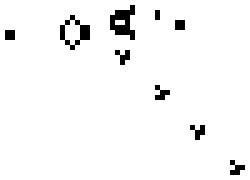

In [8]:
Image("../resources/Gospers_glider_gun.gif")
# Source: Scholarpedia

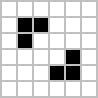

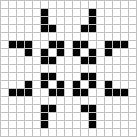

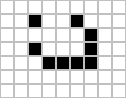

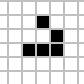

In [3]:
## Example solutions to the Game of Life

display(Image("../resources/Game_of_life_beacon.gif"))
display(Image("../resources/Game_of_life_pulsar.gif"))
display(Image("../resources/Game_of_life_animated_LWSS.gif"))
display(Image("../resources/Game_of_life_animated_glider.gif"))
# Source: Scholarpedia

# Game of Life implementation

In [13]:
# A base allows us to impose structure on specific cases. We will use this as a parent
# for subsequent classes
class CellularAutomaton:
    """
    A base class for cellular automata. Subclasses must implement the step method.

    Parameters
        n (int): The number of cells in the system
        n_states (int): The number of states in the system
        random_state (None or int): The seed for the random number generator. If None,
            the random number generator is not seeded.
        initial_state (None or array): The initial state of the system. If None, a 
            random initial state is used.
        
    """
    def __init__(self, n, n_states, random_state=None, initial_state=None):
        self.n_states = n_states
        self.n = n
        self.random_state = random_state

        np.random.seed(random_state)

        ## The universe is a 2D array of integers
        if initial_state is None:
            self.initial_state = np.random.choice(self.n_states, size=(self.n, self.n))
        else:
            self.initial_state = initial_state
        self.state = self.initial_state

        self.history = [self.state]

    def next_state(self):
        """
        Output the next state of the entire board
        """
        return NotImplementedError

    def simulate(self, n_steps):
        """
        Iterate the dynamics for n_steps, and return the results as an array
        """
        for i in range(n_steps):
            self.state = self.next_state()
            self.history.append(self.state)
        return self.state





class ExtinctionAutomaton(CellularAutomaton):
    """
    A cellular automaton that simulates the extinction of a species.
    """
    def __init__(self, n, **kwargs):
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Output the next state of the entire board
        """
        next_state = np.zeros_like(self.state)
        return next_state


class RandomAutomaton(CellularAutomaton):
    """
    A cellular automaton with random updates
    """
    def __init__(self, n, random_state=None, **kwargs):
        super().__init__(n, 2, **kwargs)
        self.random_state = random_state

    def next_state(self):
        """
        Output the next state of the entire board
        """
        next_state = np.random.choice(self.n_states, size=(self.n, self.n))
        return next_state

Text(0.5, 1.0, 'Final state')

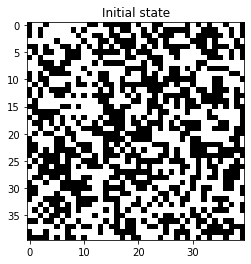

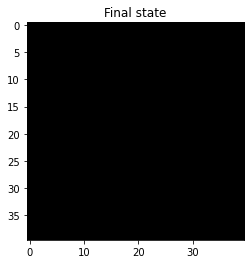

In [14]:
model = ExtinctionAutomaton(40, random_state=0)
model.simulate(200)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

Text(0.5, 1.0, 'Final state')

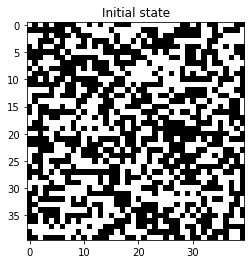

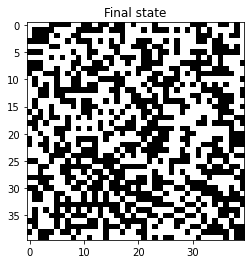

In [15]:
model = RandomAutomaton(40, random_state=0)
model.simulate(200)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

In [11]:
        
# This child class inherits methods from the parent class
class GameOfLife(CellularAutomaton):
    """
    An implementation of Conway's Game of Life in Python

    Args:
        n (int): The number of cells in the system
        **kwargs: Additional keyword arguments passed to the base CellularAutomaton class
    """

    def __init__(self, n, **kwargs):
        # the super method calls the parent class's __init__ method
        # and passes the arguments to it. It is a constructor 
        super().__init__(n, 2, **kwargs)

    def next_state(self):
        """
        Compute the next state of the board
        """
        # Compute the next state
        next_state = np.zeros_like(self.state)
        for i in range(self.state.shape[0]):
            for j in range(self.state.shape[1]):
                # Compute the number of neighbors
                n_neighbors = 0
                for ii in range(-1, 2):
                    for jj in range(-1, 2):
                        if ii == 0 and jj == 0:
                            continue
                        try:
                            n_neighbors += self.state[i + ii, j + jj]
                        except IndexError:
                            continue

                # Update the next state
                if self.state[i, j] == 1:
                    if n_neighbors in [2, 3]:
                        next_state[i, j] = 1
                else:
                    if n_neighbors == 3:
                        next_state[i, j] = 1
        return next_state

Text(0.5, 1.0, 'Final state')

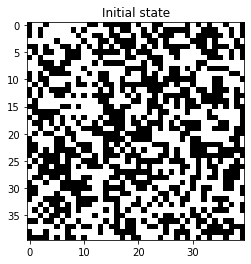

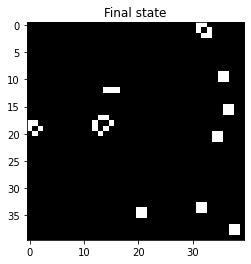

In [12]:
model = GameOfLife(40, random_state=0)
model.simulate(200)

plt.figure()
plt.imshow(model.initial_state, cmap="gray")
plt.title("Initial state")

plt.figure()
plt.imshow(model.state, cmap="gray")
plt.title("Final state")

In [12]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(model.history[i], vmin=0, vmax=1, cmap="gray")
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=200), Output()), _…

<function __main__.plotter(i)>

# Cellular automata: additional context and information

+ Cellular automata represent an intriguing example of a physical system where surprising complexity emerges from relatively simple rules.
+ Cellular automata have a rich history in the physics literature, although their popularity has declined somewhat due to a lack of analytical tools for working with their governing equations. 
+ One common criticism of Game-of-Life like CAs comes from their requirement of a *synchronous* update rule: all of the cells update to a new state at the same time: the value of a cell $x_{ij}(t+1)$ depends on the "frozen" values $x_{ij}(t)$ and its neighbors at the same instant $t$. In a real-world system, updates are asynchronous: different cells will update at different times. One way of thinking about asynchronous updates is that we only update a single cell in a given timestep, and we gradually raster-scan across the entire image to update all cells sequentially. Asynchronous update rules usually have qualitatively distinct dynamics than synchronous CA.
+ In addition to having interesting theoretical properties, there are a few natural systems that exhibit discrete, local space and time dynamics that can be well described by CA equations. My favorite example is the [skin patterning of certain lizards](https://www.nature.com/articles/nature22031)
+ While deep learning is in the news, the most popular machine learning algorithms for practical applications are likely random forests, which involve training an ensemble of small machine learning models (decision trees), and averaging their results to generate a consensus prediction or classification. A powerful variant of RF are so-called gradient-boosted decision trees, in which individual decision trees are trained sequentially based on errors from previous trees. Training random forests vs boosted trees are a nice example of a synchronous vs asynchronous algorithm.

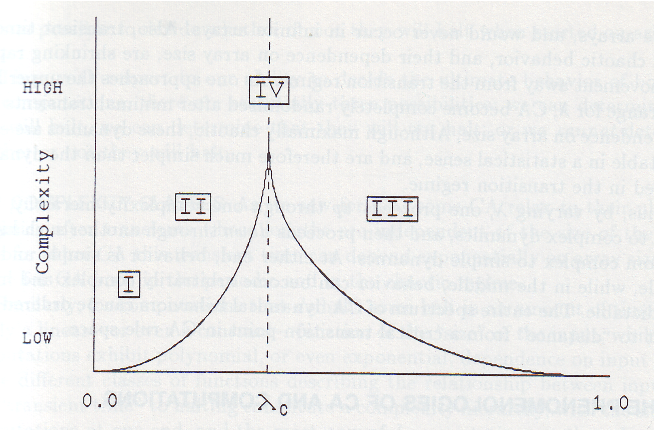

In [4]:
Image("../resources/eoc_ce_lambda.png")
# Complexity of CA dynamics vs the entropy of the rule table
# Source: Langton 1990

# The size of the (discrete) universe

+ Scaling of memory with size and rules
+ Scaling of runtime with CA ruleset

### Memory Scaling
 
+ To avoid 2D vs 3D, let's just say there are $N$ total sites. So our 2D universe is $\sqrt{N} \times \sqrt{N}$ in span, etc
+ For synchronous update rules, each site value $s_{ij}(t+1)$ at timestep $t + 1$ depends on the lattice $s_{ij}(t)$. That means that each timestep requires a full copy of the entire universe, into which we write the next states one-by-one
+ The original copy requires space $\sim N$, on top of the $\sim N$ memory requirements to store the initial lattice. So if our original lattice was 1 MP, then we need to set aside 2 MP of memory
+ The "Big-O$ notation usually ignores prefactors, and so we would say that the asymptotic space requirements to simulate the Game of Life are $\mathcal{O}(N)$

### Runtime scaling

+ Let's look at what our algorithm does carefully: at each lattice site, we poll the nearest neighbors (including diagonal neighbors), and compute a sum. We then execute a conditional on that sum to write to the future state.
+ Since every site gets updated, we know that we have to perform at least $N$ operations in order to update the entire universe
+ For each site, let's keep a running sum of all neighbors, and a check of the current value. that's $9$ operations per site
+ So the runtime looks something like $N \times 9$. Asymptotically we ignore prefactors

+ What if we had a global cellular automaton, like an N-body simulation, where we need to compute pairwise forces between all lattice sites? At least $N^2$, since we have to check every other site every time we update a single site

+ Low-level optimizations (vectorizations, convolution, etc) decrease the runtime by reducing the prefactor, but we cannot change the Big-O scaling properties, which are intrinstic to algorithms

### Some tricks for figuring out Big-O for an algorithm

+ It's almost always some combination of a polynomial $N^{\alpha}$ and $Log(N)$. Remember that overwriting values, peeking the front of a queue, etc take constant time or $\mathcal{O}(1)$
+ $Log(N)$ usually means you can do something clever (recursion, bisection search, dynamic programming, etc)
+ Exp(N) is rare and usually not optimal (describes a process that branches)
+ Stirling's approximation: $N! \sim \sqrt{N} e^{-N} N^N$ or $Log(N!) \sim N Log N$